# 泰坦尼克号获救概率预测

In [81]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import DataLoader,TensorDataset
import torch.nn.functional as F

In [82]:
data = pd.read_csv('./data/train.csv')

In [83]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [84]:
data = data[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp','Parch', 'Fare', 'Cabin', 'Embarked']]

In [85]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [86]:
data['Age'] = data['Age'].fillna(data['Age'].mean()) #平均值填充

In [87]:
data['Cabin'] = pd.factorize(data.Cabin)[0]#数值化

In [88]:
data.fillna(0,inplace=True) #剩余的缺失值用0填充

In [89]:
data['Sex'] = [1 if x == 'male' else 0 for x in data.Sex] #男变为1女变为0

In [90]:
#船舱等级变为三列 ，即one-hot编码。
#进行one-hot编码，分类变量作为二进制向量的表示。这首先要求将分类值映射到整数值。然后，每个整数值被表示为二进制向量，除了整数的索引之外，它都是零值，它被标记为1。
data['p1'] = np.array(data['Pclass'] == 1).astype(np.int32)
data['p2'] = np.array(data['Pclass'] == 2).astype(np.int32)
data['p3'] = np.array(data['Pclass'] == 3).astype(np.int32)

In [91]:
del data['Pclass']  #删除此列

In [92]:
data.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,p1,p2,p3
0,0,1,22.0,1,0,7.2500,-1,S,0,0,1
1,1,0,38.0,1,0,71.2833,0,C,1,0,0
2,1,0,26.0,0,0,7.9250,-1,S,0,0,1
3,1,0,35.0,1,0,53.1000,1,S,1,0,0
4,0,1,35.0,0,0,8.0500,-1,S,0,0,1


In [93]:
# 查看Embarked有几个特征值
data.Embarked.unique()

array(['S', 'C', 'Q', 0], dtype=object)

In [94]:
#变为三列
data['e1'] = np.array(data['Embarked'] == 'S').astype(np.int32)
data['e2'] = np.array(data['Embarked'] == 'C').astype(np.int32)
data['e3'] = np.array(data['Embarked'] == 'Q').astype(np.int32)
del data['Embarked']
data.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Cabin,p1,p2,p3,e1,e2,e3
0,0,1,22.0,1,0,7.2500,-1,0,0,1,1,0,0
1,1,0,38.0,1,0,71.2833,0,1,0,0,0,1,0
2,1,0,26.0,0,0,7.9250,-1,0,0,1,1,0,0
3,1,0,35.0,1,0,53.1000,1,1,0,0,1,0,0
4,0,1,35.0,0,0,8.0500,-1,0,0,1,1,0,0


In [95]:
data.values.dtype 

dtype('float64')

In [96]:
#划分特征x和标签y
data_train = data[[ 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'p1', 'p2','p3', 'e1', 'e2', 'e3']]
data_target = data['Survived']
#看数据集形状，有891个样本，12个特征
np.shape(data_train),np.shape(data_target)

((891, 12), (891,))

In [97]:
#切分训练集和验证集
X_train,X_val,y_train,y_val = train_test_split(data_train,data_target,test_size=0.3)
X_train = torch.from_numpy(np.array(X_train)).float()
X_val = torch.from_numpy(np.array(X_val)).float()
y_train = torch.from_numpy(np.array(y_train)).long()
y_val = torch.from_numpy(np.array(y_val)).long()
tensor_datasets = {'train': TensorDataset(X_train,y_train),'val':TensorDataset(X_val,y_val)}
dataloaders = {x: DataLoader(tensor_datasets[x], batch_size=100,
                            shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(tensor_datasets[x]) for x in ['train', 'val']}

In [98]:
class linear_Net(torch.nn.Module):
    def __init__(self):
        """
        在构造函数中，我们构造了一个nn.Linear实例，就是wx+b,它们将在前向传播时被使用。
        """
        super(linear_Net, self).__init__()
        self.input_linear = torch.nn.Linear(12, 24)
        self.middle_linear = torch.nn.Linear(24, 24)
        self.output_linear = torch.nn.Linear(24, 2)

    def forward(self, x):
        """
        前向传播
        """
        x = F.relu(self.input_linear(x))
        x = F.relu(self.middle_linear(x))
        y_pred = self.output_linear(x)
        return y_pred

In [99]:
# 创建空的列表用于存储验证集的损失和准确率
val_loss = []
val_acc = []

def train_model(model, criterion, optimizer, scheduler, num_epochs=1000):
    since = time.time()
    # 保存初始模型权重，用于记录效果更好的模型权重
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    # 开始训练
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # 每个epoch都有一个训练和验证阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # 设置模型为训练模式
            else:
                model.eval()   # 设置模型为测试模式
            # 用于损失和准确率
            running_loss = 0.0
            running_corrects = 0

            # 迭代数据
            for inputs, labels in dataloaders[phase]:

                # 零参数梯度
                optimizer.zero_grad()

                # 前向
                # 如果是训练阶段会计算梯度
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 后向传播并且仅在训练阶段进行优化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 统计损失和准确率
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # 计算每个epoch的损失和准确率
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            val_loss.append(epoch_loss)
            val_acc.append(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 如果验证集模型效果更好，就深度复制模型权重
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    
    #计算一轮次所花时间
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)
    return model

In [100]:
model_ft = linear_Net()

criterion = nn.CrossEntropyLoss()

# 观察所有参数都正在优化
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 每7个epochs衰减LR通过设置衰减率gamma=0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 1/20
----------
train Loss: 0.8028 Acc: 0.5040
val Loss: 0.7411 Acc: 0.5933

Epoch 2/20
----------
train Loss: 0.6532 Acc: 0.6565
val Loss: 0.6134 Acc: 0.6716

Epoch 3/20
----------
train Loss: 0.6471 Acc: 0.6934
val Loss: 0.6184 Acc: 0.6791

Epoch 4/20
----------
train Loss: 0.6116 Acc: 0.6934
val Loss: 0.6270 Acc: 0.6866

Epoch 5/20
----------
train Loss: 0.6032 Acc: 0.6870
val Loss: 0.6031 Acc: 0.6754

Epoch 6/20
----------
train Loss: 0.5926 Acc: 0.6870
val Loss: 0.5986 Acc: 0.6716

Epoch 7/20
----------
train Loss: 0.5953 Acc: 0.6870
val Loss: 0.5987 Acc: 0.6642

Epoch 8/20
----------
train Loss: 0.5942 Acc: 0.6950
val Loss: 0.6014 Acc: 0.6604

Epoch 9/20
----------
train Loss: 0.5911 Acc: 0.6998
val Loss: 0.6026 Acc: 0.6716

Epoch 10/20
----------
train Loss: 0.5908 Acc: 0.6998
val Loss: 0.6012 Acc: 0.6604

Epoch 11/20
----------
train Loss: 0.5900 Acc: 0.7014
val Loss: 0.6019 Acc: 0.6642

Epoch 12/20
----------
train Loss: 0.5898 Acc: 0.7014
val Loss: 0.6024 Acc: 0.6679

E

e:\Anaconda\envs\Deep\Lib\site-packages\torch\optim\lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train Loss: 0.5892 Acc: 0.7014
val Loss: 0.6019 Acc: 0.6642

Epoch 20/20
----------
train Loss: 0.5892 Acc: 0.6998
val Loss: 0.6017 Acc: 0.6642

Training complete in 0m 0s
Best val Acc: 0.686567


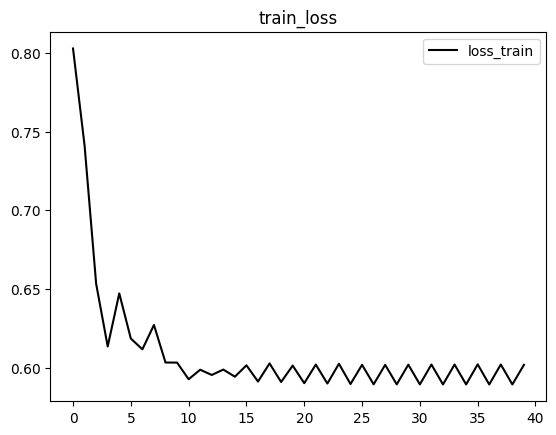

In [101]:
import matplotlib.pyplot as plt
plt.plot(val_loss,'k-',label = 'loss_train')
plt.title('train_loss')
plt.legend()
plt.show()

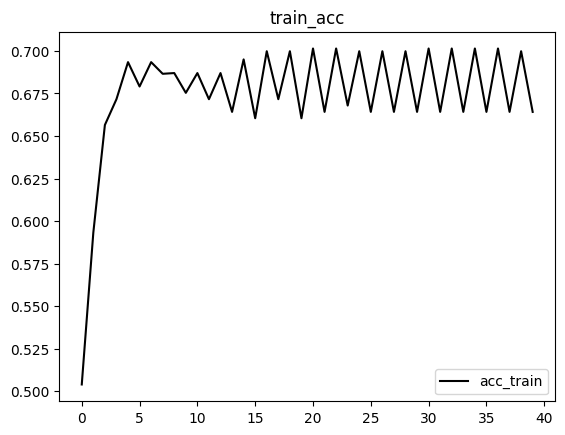

In [102]:
plt.plot(val_acc,'k-',label = 'acc_train')
plt.title('train_acc')
plt.legend()
plt.show()

# 作业内容

In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(12, 768)  # 输入层到第一隐藏层
        self.fc2 = nn.Linear(768, 224) # 第一隐藏层到第二隐藏层
        self.fc3 = nn.Linear(224, 128) # 第二隐藏层到第三隐藏层
        self.fc4 = nn.Linear(128, 64)  # 第三隐藏层到第四隐藏层
        self.fc5 = nn.Linear(64, 2)    # 第四隐藏层到输出层
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        y_pred = self.fc5(x)  # 输出层不使用激活函数
        return y_pred

# 创建网络实例
net = Net2()

# 生成一个随机输入（batch_size=1, 输入特征数=12）
input_tensor = torch.randn(1, 12)

# 进行前向传播并记录结果
output_tensor = net(input_tensor)
print("Output:", output_tensor)


Output: tensor([[-0.0217, -0.0939]], grad_fn=<AddmmBackward0>)


In [104]:
#训练
model_ft = Net2()

criterion = nn.CrossEntropyLoss()

# 观察所有参数都正在优化
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 每7个epochs衰减LR通过设置衰减率gamma=0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 1/20
----------
train Loss: 0.6927 Acc: 0.6404
val Loss: 0.6331 Acc: 0.6567

Epoch 2/20
----------
train Loss: 0.6285 Acc: 0.6790
val Loss: 0.6152 Acc: 0.6978

Epoch 3/20
----------
train Loss: 0.6136 Acc: 0.6758
val Loss: 0.6111 Acc: 0.6903

Epoch 4/20
----------
train Loss: 0.6025 Acc: 0.6790
val Loss: 0.6060 Acc: 0.6716

Epoch 5/20
----------
train Loss: 0.5960 Acc: 0.6950
val Loss: 0.6123 Acc: 0.6903

Epoch 6/20
----------
train Loss: 0.5938 Acc: 0.6982
val Loss: 0.6066 Acc: 0.6828

Epoch 7/20
----------
train Loss: 0.5904 Acc: 0.6982
val Loss: 0.6057 Acc: 0.6828

Epoch 8/20
----------
train Loss: 0.5900 Acc: 0.6982
val Loss: 0.6056 Acc: 0.6866

Epoch 9/20
----------
train Loss: 0.5898 Acc: 0.6982
val Loss: 0.6045 Acc: 0.6791

Epoch 10/20
----------
train Loss: 0.5894 Acc: 0.6982
val Loss: 0.6043 Acc: 0.6828

Epoch 11/20
----------
train Loss: 0.5892 Acc: 0.6982
val Loss: 0.6040 Acc: 0.6828

Epoch 12/20
----------
train Loss: 0.5890 Acc: 0.6966
val Loss: 0.6043 Acc: 0.6866

E

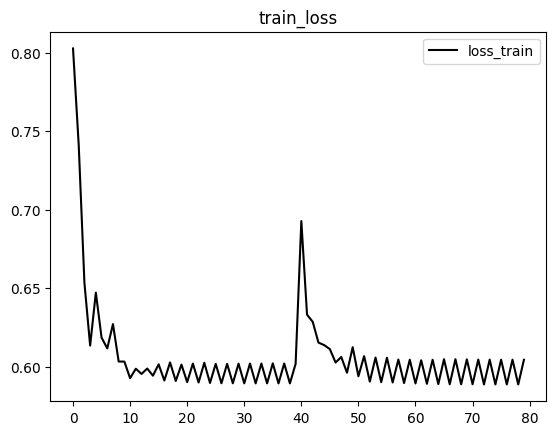

In [105]:
import matplotlib.pyplot as plt
plt.plot(val_loss,'k-',label = 'loss_train')
plt.title('train_loss')
plt.legend()
plt.show()

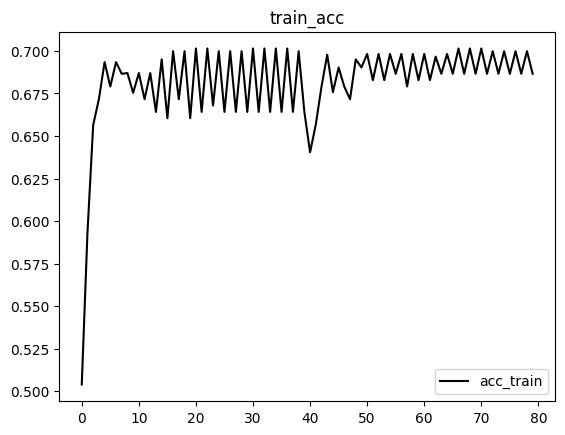

In [106]:
plt.plot(val_acc,'k-',label = 'acc_train')
plt.title('train_acc')
plt.legend()
plt.show()